In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

In [2]:
eth = pd.read_csv ('./eth.csv', encoding='unicode_escape')

In [3]:
eth['time'] = eth['time'].str.extract('(\d{4}-\d{2}-\d{2}\w\d{2}:\d{2}:\d{2})', expand=True)
eth['time'] = pd.to_datetime(eth["time"])
eth.set_index("time", inplace = True)

In [4]:
def sell_RSI(eth):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(len(eth)):
    if (eth ['RSI'][i] > 77):
      if flag != 1:
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(eth['close'][i])
        flag = 1
      else:
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
    elif (eth ["RSI"][i] < 25):
      if flag != 0:
        sigPriceBuy.append(eth["close"][i])
        sigPriceSell.append(np.nan)
        flag = 0
      else:
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
    else:
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  return(sigPriceSell, sigPriceBuy)

In [5]:
sell_RSI = sell_RSI(eth)
eth['Short Signal RSI'] = sell_RSI[0]
eth['Close Short Signal RSI'] = sell_RSI[1]
# To show the data
eth.head()

,close,Volume,K,RSI,Short Signal RSI,Close Short Signal RSI
time,,,,,,
2022-10-31 01:00:00,1590.50,1817.27,NaN,NaN,NaN,NaN
2022-10-31 01:05:00,1593.05,2833.78,NaN,NaN,NaN,NaN
2022-10-31 01:10:00,1593.90,3093.07,NaN,NaN,NaN,NaN
2022-10-31 01:15:00,1594.40,1552.15,NaN,NaN,NaN,NaN
2022-10-31 01:20:00,1593.10,3074.94,NaN,NaN,NaN,NaN


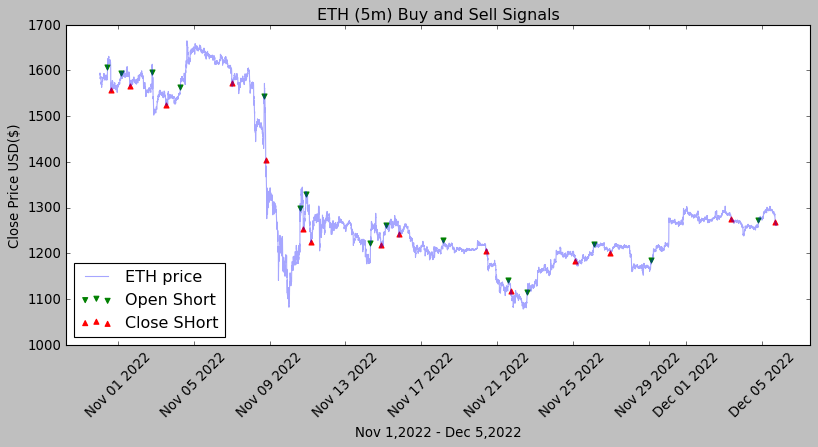

In [6]:
plt.style.use('classic')
plt.figure(figsize=(12,5))
plt.plot(eth['close'], label='ETH price', alpha=0.35)
plt.plot(eth['Short Signal RSI'], label='', alpha=0.35)
plt.plot(eth['Close Short Signal RSI'],label='', alpha=0.35)
plt.scatter(eth.index, eth['Short Signal RSI'], label ='Open Short', marker='v',color='green')
plt.scatter(eth.index, eth['Close Short Signal RSI'], label='Close SHort', marker='^', color='red')
plt.title('ETH (5m) Buy and Sell Signals')
plt.xlabel("Nov 1,2022 - Dec 5,2022")
plt.xticks(rotation = '45')
plt.ylabel("Close Price USD($)")
plt.legend(loc='lower left')
plt.show()

In [7]:
df = eth.loc[(eth["Short Signal RSI"].notnull()) | (eth["Close Short Signal RSI"].notnull())]
#df = df.drop(df.index[0]).drop(df.index[-1])
#df = df.drop(df.index[0])
df.head()

,close,Volume,K,RSI,Short Signal RSI,Close Short Signal RSI
time,,,,,,
2022-10-31 10:40:00,1608.25,37288.95,1.000000e+02,79.009519,1608.25,NaN
2022-10-31 14:55:00,1557.95,91115.11,-4.740000e-15,13.004337,NaN,1557.95
2022-11-01 03:45:00,1593.55,6541.43,1.000000e+02,78.681009,1593.55,NaN
2022-11-01 15:05:00,1565.15,17872.79,1.036177e+01,24.861468,NaN,1565.15
2022-11-02 19:10:00,1596.25,28914.37,9.911900e+01,77.310807,1596.25,NaN


In [8]:
open_list = list(df["Short Signal RSI"])
close_list = list(df["Close Short Signal RSI"])
open = [x for x in open_list if np.isnan(x) == False]
close = [x for x in close_list if np.isnan(x) == False]

In [9]:
positions = {'Open': open, 'Close': close}
positions = pd.DataFrame(positions)
positions

,Open,Close
0,1608.25,1557.95
1,1593.55,1565.15
2,1596.25,1524.15
3,1563.00,1572.45
4,1543.40,1403.10
5,1298.15,1253.60
6,1330.00,1224.05
7,1223.45,1218.35
8,1261.25,1241.55
9,1228.40,1205.70


In [10]:
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) * 100


In [11]:
positions['Gained or Lost %'] = percentage_change(positions['Close'],positions['Open'])  
positions['Real money when risk is 30$'] = positions['Gained or Lost %'] * 10  

In [12]:
positions["Real money when stop loss at 3%"] = np.where(positions["Real money when risk is 30$"] < -30, -30, positions["Real money when risk is 30$"])
positions.loc["Row_Total"] = positions.sum()
positions

,Open,Close,Gained or Lost %,Real money when risk is 30$,Real money when stop loss at 3%
0,1608.25,1557.95,3.228602,32.286017,32.286017
1,1593.55,1565.15,1.814523,18.145226,18.145226
2,1596.25,1524.15,4.730506,47.305055,47.305055
3,1563.00,1572.45,-0.600973,-6.009730,-6.009730
4,1543.40,1403.10,9.999287,99.992873,99.992873
5,1298.15,1253.60,3.553765,35.537652,35.537652
6,1330.00,1224.05,8.655692,86.556922,86.556922
7,1223.45,1218.35,0.418599,4.185989,4.185989
8,1261.25,1241.55,1.586726,15.867263,15.867263
9,1228.40,1205.70,1.882724,18.827237,18.827237


In [13]:
(positions["Real money when stop loss at 3%"] > 0).value_counts()

True     13
False     3
Name: Real money when stop loss at 3%, dtype: int64